In [135]:
import pickle
import openslide
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.metrics import roc_auc_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import imageio
from skimage.color import rgb2gray
import cv2 as cv
from PIL import Image
import PIL.ImageDraw as ImageDraw

### Load in `.sav` , `.svs` and `.xml`

In [136]:
# Load in the file saving all the processing information
with open('/home/zhenzhen/MIL-seg/results/anders/anders_segmentation.sav','rb') as handle:
    dat = pickle.load(handle)
handle.close()
meta = pd.read_csv('/home/zhenzhen/MIL-seg/meta_anders.csv')

slide_id = '458599'
slide = openslide.OpenSlide('/mnt/data0/zhenzhen/anders/'+slide_id+'.svs')
slide_info = dat[slide_id]
slide_annot = ET.parse('/mnt/data0/zhenzhen/anders/'+slide_id+'.xml').getroot()

Tile = np.load('results/tile_'+slide_id+'_92_1_0.npy')

### Basic Information
* Thumbnail
* Tissue Mask
* Tiles

In [137]:
def read_annotation(root):
    points_arr_tumor = []
    points_arr_stroma = []
    for r in root.iter('Annotation'):
        if r.attrib['Id']== '1':
            for v in r.iter('Vertex'):
                points_arr_tumor.append((int(v.attrib['X']), int(v.attrib['Y'])))
        if r.attrib['Id']== '2':
            for v in r.iter('Vertex'):
                points_arr_stroma.append((int(v.attrib['X']), int(v.attrib['Y'])))
    return points_arr_tumor, points_arr_stroma

(39839, 26746) / {'width': 39839, 'height': 26746}
92 {'tumor': 26261, 'stroma': 39029} {'tolerant_mean_band': 10, 'mean_reference': 242, 'fill_ratio_threshold': 0.6} {'tumor': 10979, 'stroma': 18860}


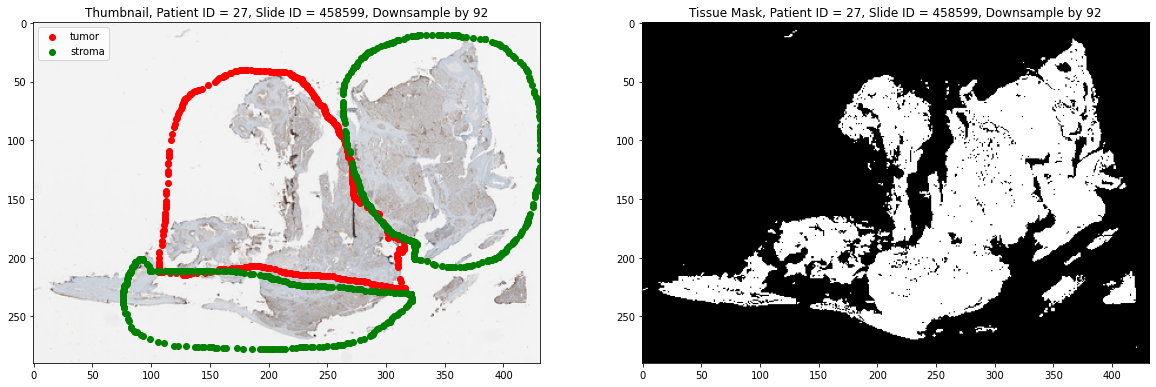

In [138]:
# Thumbnail
f,ax = plt.subplots(1,2,figsize=(20,10))
width,height = slide.dimensions
thumbnail_factor = 92
points_arr_tumor, points_arr_stroma = read_annotation(slide_annot)
tumor_x = [i[0]//thumbnail_factor for i in points_arr_tumor ]
tumor_y = [i[1]//thumbnail_factor for i in points_arr_tumor ]
stroma_x = [i[0]//thumbnail_factor for i in points_arr_stroma ]
stroma_y = [i[1]//thumbnail_factor for i in points_arr_stroma ]
ax[0].imshow(slide.get_thumbnail((width//thumbnail_factor,height//thumbnail_factor)))
ax[0].scatter(tumor_x,tumor_y, c='r',label = 'tumor')
ax[0].scatter(stroma_x,stroma_y, c='g',label = 'stroma')
ax[0].legend()
ax[0].set_title("Thumbnail, Patient ID = {}, Slide ID = {}, Downsample by {}".format(slide_info['patient_id'],slide_id,thumbnail_factor))


thumbnail = np.array(slide.get_thumbnail((width//thumbnail_factor,height//thumbnail_factor)))
thumbnail = cv.cvtColor(thumbnail,cv.COLOR_RGB2GRAY)
_,mask = cv.threshold(thumbnail,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
mask = abs(mask-255)
ax[1].imshow(mask,'gray')
ax[1].set_title("Tissue Mask, Patient ID = {}, Slide ID = {}, Downsample by {}".format(slide_info['patient_id'],slide_id,thumbnail_factor))

f.show()

print(slide.dimensions,'/',slide_info['slide_size']) # Size
print(slide_info['patch_shape'],slide_info['all_patches'],slide_info['Train']['non_blank_request'],slide_info['Train']['non_blank_patches']) # Tiles

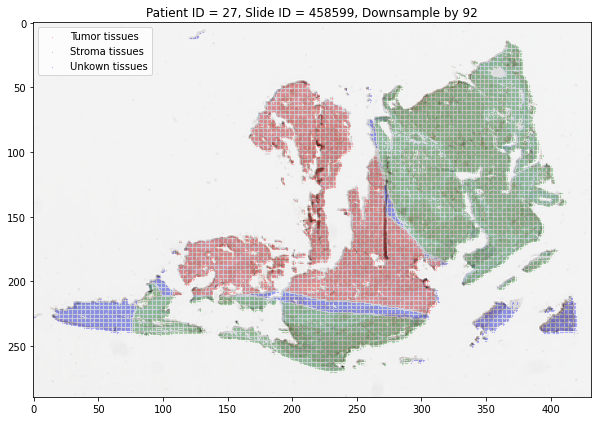

In [143]:
'''
Show grid
'''
# Tile[:,:,0] Annotation Mask  #1tumor, 2stroma, 3intersection,0unkown
# Tile[:,:,1] Tissue Mask
NROW,NCOL = Tile[:,:,0].shape
Y_tumor,X_tumor= np.where((Tile[:,:,0]==1) & (Tile[:,:,1]==1))
Y_stroma,X_stroma= np.where((Tile[:,:,0]==2) & (Tile[:,:,1]==1))
Y_unkown,X_unkown= np.where((Tile[:,:,0]==0) & (Tile[:,:,1]==1))
#IDs = [X[i]*NROW+Y[i] for i in range(len(Y))]
f,ax = plt.subplots(figsize=(10,10))
ax.imshow(slide.get_thumbnail((width//thumbnail_factor,height//thumbnail_factor)))
ax.scatter(X_tumor,Y_tumor,c='r',s=0.01,label="Tumor tissues")
ax.scatter(X_stroma,Y_stroma,c='g',s=0.01,label="Stroma tissues")
ax.scatter(X_unkown,Y_unkown,c='b',s=0.01,label="Unkown tissues")
ax.set_title("Patient ID = {}, Slide ID = {}, Downsample by {}".format(slide_info['patient_id'],slide_id,thumbnail_factor))
ax.legend()
f.show()

### Training Process
* Accuracy curve
* Loss curve
* ROC curve

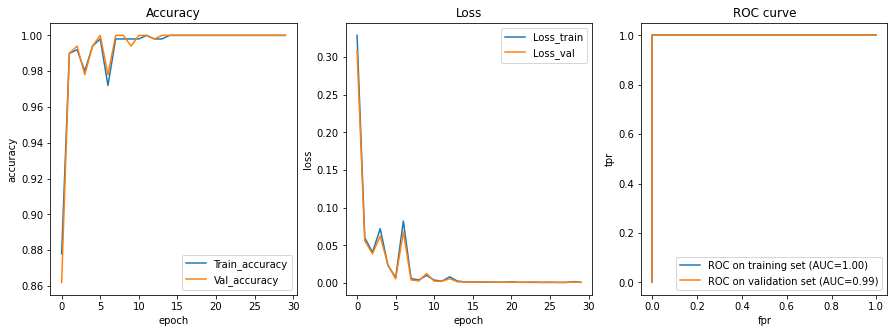

In [144]:
f,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot([float(i) for i in slide_info['Train']['metrics']['Train_accuracy']],label='Train_accuracy')
ax[0].plot([float(i) for i in slide_info['Train']['metrics']['Val_accuracy']],label='Val_accuracy')
ax[1].plot([float(i) for i in slide_info['Train']['metrics']['Loss_train'][1:-1].split(',')],label='Loss_train')
ax[1].plot([float(i) for i in slide_info['Train']['metrics']['Loss_val'][1:-1].split(',')],label='Loss_val')
fpr = [float(i) for i in slide_info['Train']['metrics']['fpr_train']]
tpr = [float(i) for i in slide_info['Train']['metrics']['tpr_train']]
roc_auc_train =  roc_auc_score(fpr,tpr)
ax[2].plot(fpr,tpr, label = "ROC on training set (AUC=%.2f)" % roc_auc_train)
fpr = [float(i) for i in slide_info['Train']['metrics']['fpr_val']]
tpr = [float(i) for i in slide_info['Train']['metrics']['tpr_val']]
roc_auc_val =  roc_auc_score(fpr,tpr)
ax[2].plot(fpr,tpr, label = "ROC on validation set (AUC=%.2f)" % roc_auc_val)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set(title="Accuracy",xlabel="epoch",ylabel='accuracy')
ax[1].set(title="Loss",xlabel="epoch",ylabel='loss')
ax[2].set(title="ROC curve",xlabel="fpr",ylabel='tpr')
f.show()

### Heatmap

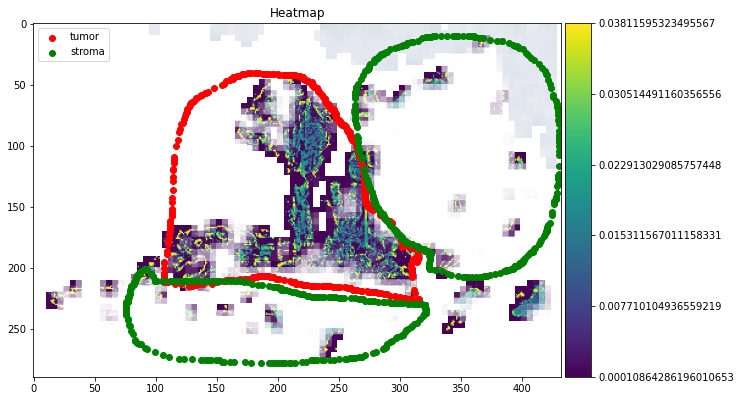

In [145]:
hot_map_instance = np.load(os.path.join('/home/zhenzhen/MIL-seg/results/anders/'+slide_id+'/neighbor/hot_map_instance.npy'))
hot_map_bag = np.load(os.path.join('/home/zhenzhen/MIL-seg/results/anders/'+slide_id+'/neighbor/hot_map_bag.npy'))

vmin = np.nanpercentile(hot_map_instance[hot_map_bag>0.5],5)
vmax = np.nanpercentile(hot_map_instance[hot_map_bag>0.5],95)
hot_map_instance_01 = (hot_map_instance-vmin)/(vmax-vmin)
cmap = cm.get_cmap()
RGBA = cmap(hot_map_instance_01)
RGBA[...,-1]= hot_map_bag

f,ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right',size='5%',pad=0.05)
im = ax.imshow(RGBA)
cb = f.colorbar(im, cax = cax, orientation='vertical')
ticks = cb.get_ticks()
cb.set_ticks(ticks)
cb.set_ticklabels(ticks*(vmax-vmin) + vmin)

ax.scatter(tumor_x,tumor_y, c='r',label = 'tumor')
ax.scatter(stroma_x,stroma_y, c='g',label = 'stroma')
ax.legend()

ax.set_title("Heatmap")
f.show()